In [3]:

# import libs
import keras
from keras.datasets import cifar10

In [4]:
# load cifar10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# convert the data type 
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize to one
X_train /= 255
X_test /= 255
# center
X_train -= 0.5
X_test -= 0.5
# one hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print (X_train.shape,y_train.shape,X_test.shape,y_test.shape)

170500096/170498071 [==============================] - 416s 2us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [28]:
# define hyper parameters
L2_REGULARIZER = 1e-4
BATCH = 128
EPOCH = 70
MOMENTUM = 0.9
LEARNING_RATE = {i: 0.01/(10**(i//20)) for i in range(EPOCH+1)}
SHAPE = (32,32,3)


create cnn model - resnet18


In [29]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Input, Flatten
from keras.regularizers import l2
from keras.models import Model

In [30]:
def block(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu'):
    x = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same',
               kernel_initializer='he_normal', kernel_regularizer=l2(L2_REGULARIZER))(inputs)
    x = BatchNormalization()(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

In [31]:
def resnet18(input_shape):
    inputs = Input(shape=input_shape)

    # build layers
    x = block(inputs)
    for i in range(6):
        branch1 = block(inputs=x)
        branch2 = block(inputs=branch1, activation=None)
        x = keras.layers.add([x, branch2])
        x = Activation('relu')(x)
    for i in range(6):
        if i == 0:
            branch1 = block(inputs=x, strides=2, num_filters=16)
        else:
            branch1 = block(inputs=x, num_filters=16)
        branch2 = block(inputs=branch1, activation=None, num_filters=16)
        if i == 0:
            x = Conv2D(16, kernel_size=3, strides=2, padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=l2(L2_REGULARIZER))(x)
        x = keras.layers.add([x, branch2])
        x = Activation('relu')(x)
    for i in range(6):
        if i == 0:
            branch1 = block(inputs=x, strides=2, num_filters=32)
        else:
            branch1 = block(inputs=x, num_filters=32)

        branch2 = block(inputs=branch1, activation=None, num_filters=32)
        if i == 0:
            x = Conv2D(32, kernel_size=3, strides=2, padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=l2(L2_REGULARIZER))(x)
        x = keras.layers.add([x, branch2])
        x = Activation('relu')(x)
    # output
    x = GlobalAveragePooling2D()(x)
    # out:10
    outputs = Dense(10, activation='softmax')(x)

    resnet = Model(inputs=inputs, outputs=outputs)
    return resnet

train the network

In [32]:
from keras.optimizers import SGD
from keras.callbacks import  LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [33]:
print (LEARNING_RATE)
resnet = resnet18(SHAPE)
resnet.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=MOMENTUM), metrics=['accuracy'])
resnet.summary()
# learning rate
learn_rate = LearningRateScheduler(lambda x:LEARNING_RATE[x])
# image augmentation
imageAugment = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
imageAugment.fit(X_train)
generator = imageAugment.flow(X_train, y_train, batch_size=BATCH)
# train
result = resnet.fit_generator(generator=generator, steps_per_epoch=50000 // BATCH, epochs=EPOCH,
                        validation_data=(X_test, y_test),
                        callbacks=[learn_rate]) 

{0: 0.01, 1: 0.01, 2: 0.01, 3: 0.01, 4: 0.01, 5: 0.01, 6: 0.01, 7: 0.01, 8: 0.01, 9: 0.01, 10: 0.01, 11: 0.01, 12: 0.01, 13: 0.01, 14: 0.01, 15: 0.01, 16: 0.01, 17: 0.01, 18: 0.01, 19: 0.01, 20: 0.001, 21: 0.001, 22: 0.001, 23: 0.001, 24: 0.001, 25: 0.001, 26: 0.001, 27: 0.001, 28: 0.001, 29: 0.001, 30: 0.001, 31: 0.001, 32: 0.001, 33: 0.001, 34: 0.001, 35: 0.001, 36: 0.001, 37: 0.001, 38: 0.001, 39: 0.001, 40: 0.0001, 41: 0.0001, 42: 0.0001, 43: 0.0001, 44: 0.0001, 45: 0.0001, 46: 0.0001, 47: 0.0001, 48: 0.0001, 49: 0.0001, 50: 0.0001, 51: 0.0001, 52: 0.0001, 53: 0.0001, 54: 0.0001, 55: 0.0001, 56: 0.0001, 57: 0.0001, 58: 0.0001, 59: 0.0001, 60: 1e-05, 61: 1e-05, 62: 1e-05, 63: 1e-05, 64: 1e-05, 65: 1e-05, 66: 1e-05, 67: 1e-05, 68: 1e-05, 69: 1e-05, 70: 1e-05}
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)          

Epoch 1/70
390/390 [==============================] - 37s 95ms/step - loss: 1.9153 - acc: 0.3563 - val_loss: 2.2997 - val_acc: 0.2989
Epoch 2/70
390/390 [==============================] - 23s 59ms/step - loss: 1.5960 - acc: 0.4754 - val_loss: 1.5509 - val_acc: 0.5004
Epoch 3/70
390/390 [==============================] - 23s 60ms/step - loss: 1.4294 - acc: 0.5434 - val_loss: 1.3638 - val_acc: 0.5612
Epoch 4/70
390/390 [==============================] - 23s 59ms/step - loss: 1.3167 - acc: 0.5826 - val_loss: 1.6297 - val_acc: 0.4962
Epoch 5/70
390/390 [==============================] - 23s 59ms/step - loss: 1.2185 - acc: 0.6183 - val_loss: 1.4393 - val_acc: 0.5542
Epoch 6/70
390/390 [==============================] - 23s 59ms/step - loss: 1.1501 - acc: 0.6415 - val_loss: 1.4699 - val_acc: 0.5522
Epoch 7/70
390/390 [==============================] - 23s 59ms/step - loss: 1.0943 - acc: 0.6654 - val_loss: 1.1843 - val_acc: 0.6367
Epoch 8/70
390/390 [==============================] - 23s 59ms

Epoch 62/70
390/390 [==============================] - 22s 57ms/step - loss: 0.5416 - acc: 0.8612 - val_loss: 0.6503 - val_acc: 0.8264
Epoch 63/70
390/390 [==============================] - 22s 56ms/step - loss: 0.5440 - acc: 0.8602 - val_loss: 0.6494 - val_acc: 0.8267
Epoch 64/70
390/390 [==============================] - 22s 57ms/step - loss: 0.5411 - acc: 0.8601 - val_loss: 0.6504 - val_acc: 0.8270
Epoch 65/70
390/390 [==============================] - 22s 57ms/step - loss: 0.5434 - acc: 0.8596 - val_loss: 0.6489 - val_acc: 0.8279
Epoch 66/70
390/390 [==============================] - 22s 57ms/step - loss: 0.5426 - acc: 0.8600 - val_loss: 0.6496 - val_acc: 0.8267
Epoch 67/70
390/390 [==============================] - 22s 56ms/step - loss: 0.5436 - acc: 0.8591 - val_loss: 0.6489 - val_acc: 0.8269
Epoch 68/70
390/390 [==============================] - 22s 57ms/step - loss: 0.5419 - acc: 0.8601 - val_loss: 0.6504 - val_acc: 0.8262
Epoch 69/70
390/390 [==============================] - 

dict_keys(['val_loss', 'val_acc', 'acc', 'loss', 'lr'])


Text(0.5, 1.0, 'Accuracy')

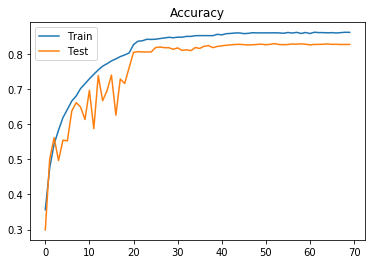

In [39]:
print (result.history.keys())
train_accuracy, train_loss, val_accuracy, val_loss = result.history['acc'], result.history['loss'], result.history['val_acc'], result.history['val_loss']
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(train_accuracy)), train_accuracy, label='Train')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Test')
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

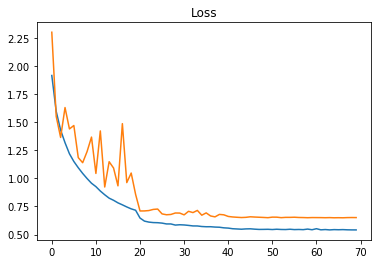

In [44]:
plt.plot(range(len(train_loss)), train_loss, label='Train')
plt.plot(range(len(val_loss)), val_loss, label='Test')
plt.title('Loss')



save model

In [45]:
resnet.save_weights("resnet18_cifar10.h5")